In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import tracker
import stats
import visualizer
import utils

import importlib

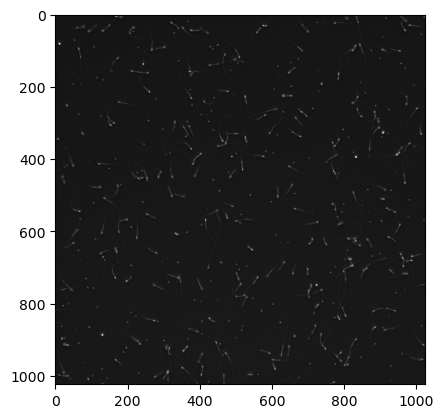

In [2]:
videofile = "ExampleVideos/10X_LD_1024_R1.avi"

# Visualize the input
cap = cv2.VideoCapture(videofile)

# Get the first frame
ret, frame = cap.read()

plt.imshow(frame)

In [35]:
importlib.reload(tracker)
importlib.reload(utils)

bw2 = tracker.threshold(frame, method='hybrid')
_, label_im, stats, _ = cv2.connectedComponentsWithStats(bw2, 4, cv2.CV_32S)

# Seperate bbox from area
areas = stats[:,4]
bboxs = stats[:,0:4]

# Filter out the background (always index 0)
areas = areas[1:]
bboxs = bboxs[1:]
label_im -= 1


# Find centroids by focusing on heads
bw = tracker.threshold(frame, method='otsu')
kernel = np.ones((3,3),np.uint8)
bw = cv2.morphologyEx(bw, cv2.MORPH_OPEN, kernel)
_, _, _, centroids = cv2.connectedComponentsWithStats(bw, 4, cv2.CV_32S) 

# Filter out the background (always index 0)
centroids = centroids[1:]


In [62]:
def separate_segmentations(label_im,centroids,areas,bboxs):

    # Create a new label image
    new_label_im = np.copy(label_im)
    new_areas = np.copy(areas)
    new_bboxs = np.copy(bboxs)

    # Find where each centroid lands
    matches = {}

    for i, centroid in enumerate(centroids):
        x,y = centroid
        r,c = int(y),int(x)
        if r < 0 or c < 0 or r >= label_im.shape[0] or c >= label_im.shape[1]:
            print("Warning: Centroid found out of bounds")
            continue

        # Check the label of the four surrounding pixels    
        r2 = r+1 if r+1 < label_im.shape[0] else r
        c2 = c+1 if c+1 < label_im.shape[1] else c
        label_tl = label_im[r,c]
        label_tr = label_im[r,c2]
        label_bl = label_im[r2,c]
        label_br = label_im[r2,c2]
        
        if label_tl >= 0:
            label = label_tl
        elif label_tr >= 0:
            label = label_tr
        elif label_bl >= 0:
            label = label_bl
        else:
            label = label_br
            # TODO: Check mode of the four labels if they are greater than 1

        if label in matches:
            matches[label].append(i)
        else:
            matches[label] = [i]
        

    count = 0
    del_labels = []

    for label, match in matches.items():
        if len(match) > 1:

            del_labels.append(label)

            # Find the closest centroid for each pixel
            pixels = np.where(label_im == label)

            # Make new labels
            label_list = np.amax(new_label_im) + 1 + np.arange(len(match))

            print(label_list)

            # Find the closest centroid for each pixel
            for p in range(len(pixels[0])):
                r = pixels[0][p]
                c = pixels[1][p]
                pixel = np.array([c,r])
                distances = [np.linalg.norm(centroids[i] - pixel) for i in match]
                closest = np.argmin(distances)
                new_label_im[r,c] = label_list[closest]
            
            # Find the bounding boxes and areas of the new labels
            for new_label in label_list:
                pixels = np.where(new_label_im == new_label)
                x = np.amin(pixels[1])
                y = np.amin(pixels[0])
                w = np.amax(pixels[1]) - x
                h = np.amax(pixels[0]) - y
                area = len(pixels[0])
                bbox = np.array([[x,y,w,h]])
                new_areas = np.append(new_areas,area)
                new_bboxs = np.append(new_bboxs,bbox,axis=0)

            print(len(new_areas))

            count += 1


    
    print("Resolved {} crossovers".format(count))

    return new_label_im, new_areas, new_bboxs

new_label_im, new_areas, new_bboxs = separate_segmentations(label_im,centroids,areas,bboxs)

[5894 5895]
5896
[5896 5897]
5898
[5898 5899]
5900
[5900 5901]
5902
[5902 5903]
5904
[5904 5905]
5906
[5906 5907]
5908
[5908 5909]
5910
[5910 5911]
5912
[5912 5913]
5914
[5914 5915]
5916
[5916 5917]
5918
[5918 5919]
5920
[5920 5921]
5922
[5922 5923]
5924
[5924 5925]
5926
[5926 5927 5928]
5929
[5929 5930]
5931
[5931 5932]
5933
[5933 5934 5935]
5936
[5936 5937]
5938
[5938 5939]
5940
[5940 5941]
5942
[5942 5943]
5944
[5944 5945 5946]
5947
[5947 5948]
5949
[5949 5950]
5951
[5951 5952]
5953
[5953 5954]
5955
[5955 5956]
5957
[5957 5958]
5959
[5959 5960 5961 5962]
5963
[5963 5964]
5965
[5965 5966]
5967
[5967 5968]
5969
[5969 5970]
5971
[5971 5972]
5973
[5973 5974 5975]
5976
[5976 5977 5978]
5979
[5979 5980 5981]
5982
[5982 5983]
5984
[5984 5985]
5986
[5986 5987]
5988
[5988 5989]
5990
[5990 5991]
5992
[5992 5993]
5994
[5994 5995 5996]
5997
[5997 5998]
5999
[5999 6000]
6001
Resolved 49 crossovers


6000
(6001, 4)
(6001,)


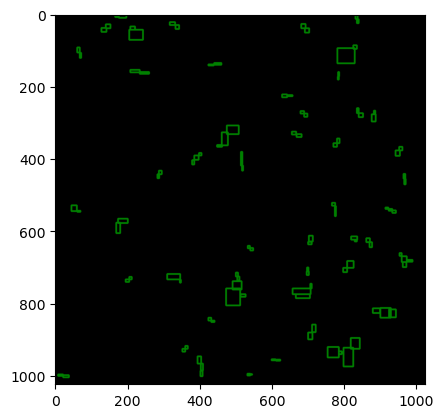

In [64]:
visualize = np.zeros_like(frame)

print(np.amax(new_label_im))
print(new_bboxs.shape)
print(new_areas.shape)

for i in range(5894,np.amax(new_label_im)+1):
    bbox = new_bboxs[i]
    x = int(bbox[0])
    y = int(bbox[1])
    w = int(bbox[2])
    h = int(bbox[3])
    visualize = cv2.rectangle(visualize, (x, y), (x + w, y + h), (0, 128, 0), 3)

plt.imshow(visualize)

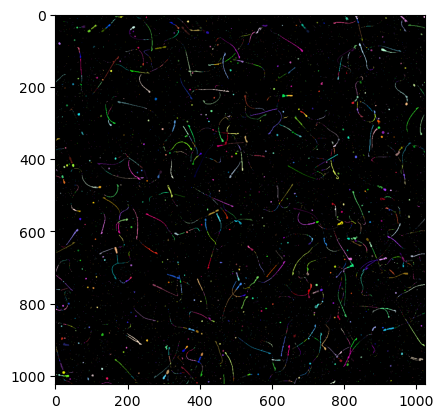

In [53]:
colors = np.random.randint(0, 255, (np.amax(new_label_im)+1, 3))

visualize = np.zeros_like(frame)

for i in range(np.amax(new_label_im)+1):
    color = colors[i]
    visualize[np.where(new_label_im==i)] = color

plt.imshow(visualize)

### Feed through the tracking pipeline

In [3]:
importlib.reload(tracker)
importlib.reload(utils)

frames = utils.loadVideo(videofile,as_gray=True)
f = tracker.determineCentroids(frames)
t = tracker.trackCentroids(f)

print(t.head())

Frame 499: 419 trajectories present.
            y           x         mass      size       ecc     signal  \
0  711.769841  798.759463  1074.533618  2.031648  0.131896  79.376415   
1  711.000999  598.101898   656.659433  2.969879  0.618657  30.176158   
2  709.820089  928.341386  1031.893395  2.662399  0.480111  53.792281   
3  706.531780  509.604873   619.267238  1.900323  0.066527  44.608233   
4  705.619266  699.021407  1287.078729  2.372004  0.291839  74.128388   

   raw_mass        ep  frame  sperm  
0    4338.0  0.014547      0      1  
1    3291.0  0.025457      0      2  
2    4215.0  0.015318      0      3  
3    2965.0  0.033214      0      5  
4    4577.0  0.013250      0      6  


In [6]:
importlib.reload(tracker)

final = tracker.segmentCells(frames, t)

print(final.head())

  0%|          | 0/500 [00:00<?, ?it/s]

 52%|█████▏    | 262/500 [03:04<02:48,  1.42it/s]


KeyboardInterrupt: 

In [ ]:
utils.saveDataFrame(final, videofile.split('.')[0] + '_tracked.csv')

### Feed through the statistics pipeline

In [4]:
importlib.reload(stats)

final_withstats = stats.calcAverageSpeed(final)

print(final_withstats.head())

In [ ]:
utils.saveDataFrame(final_withstats, videofile.split('.')[0] + '_tracked_withstats.csv')

### Use Visualizations

In [ ]:
importlib.reload(visualizer)

visualizer.runVisualization(videofile, final_withstats, visualization="segments")